In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import math

### <b> Temperature profile through lava before solidifcation - test run </b>

### Step 1: Choose a value for surface temperature and compute lambda

In [2]:
L = 320e3                 ## latent heat capacity in J/kg; value from Wittmann et al.2017
c =  1200                 ## specific heat capacity in J/kg/K; value from Wittman et al. 2017
k = 3                     ## thermal conductivity in W/m/K from Head and Wilson 1986, and Davies et al., 2005
kappa = 5e-7              ## thermal diffusivity in m2/s; value from Wittman et al. 2017 - Table 2 Peck (1978)

T_magma = 1100+273        ## magma liquidus emplacement temperature in K
T_surf = 737          ## venus atmospheric temperature

RHS = L * np.pi ** 0.5 / c / (T_magma - T_surf)
print(RHS)

0.7431672330840736


In [3]:
lambda_up = np.arange(1.5, 0, -1e-5)
lambda_down = np.arange(1.5, 0, -1e-5)
def LHS_up(lambda_0):
    LHS = np.exp(-1*lambda_0**2) / lambda_0 / erf(lambda_0)
    return LHS

def LHS_down(lambda_0):
    LHS = np.exp(-1*lambda_0**2) / lambda_0 / (1+erf(lambda_0))
    return LHS

def temp_lower_crust(Tlava, Tsub, l, kappa, thickness, time):
    m = (Tlava - Tsub) / (1+erf(l))
    n = 1 + erf(thickness / 2 / (kappa*time)**0.5)
    return ((m*n) + Tsub)

def temp_upper_crust(Tlava, Tsurf, l, kappa, thickness, time):
    m = (Tlava - Tsurf) / erf(l)
    n = erf(thickness / 2 / (kappa*time)**0.5)
    return (m*n) + Tsurf

In [4]:
solution_up = RHS - LHS_up(lambda_up) 
print("lambda_up = ", lambda_up[np.argmin(np.abs(solution_up))])
print("minimum = ", LHS_up(lambda_up[np.argmin(np.abs(solution_up))]) - RHS)
l_up = lambda_up[np.argmin(np.abs(solution_up))]

lambda_up =  0.8492599999957369
minimum =  4.162498710935658e-06


In [5]:
solution_down = RHS - LHS_down(lambda_down) 
print("lambda_up = ", lambda_down[np.argmin(np.abs(solution_down))])
print("minimum = ", LHS_down(lambda_down[np.argmin(np.abs(solution_down))]) - RHS)
l_down = lambda_down[np.argmin(np.abs(solution_down))]

lambda_up =  0.5926399999940557
minimum =  3.35863379052892e-06


### Proper iteration - doesn't work for lambda_up

In [ ]:
lambda_init = 1.7
while True:
    lambda_final = c * (T_magma - T_surf) * np.exp(-1*lambda_init**2) / (L * np.pi**0.5 * math.erf(lambda_init))
    temp = lambda_init
    lambda_init = lambda_final
    print(temp, lambda_init)
    if (abs(temp - lambda_init) <= 0.001):
        lambda_upper = lambda_final
        break

In [ ]:
lambda_init = 0.5
while True:
    lambda_final = c * (T_magma - T_surf) * np.exp(-1*lambda_init**2) / (L * np.pi**0.5 * (1+math.erf(lambda_init)))
    temp = lambda_init
    lambda_init = lambda_final
    if (abs(temp - lambda_init) <= 0.0001):
        lambda_lower = lambda_final
        break
        
print(lambda_lower)

### Step 2: Compute time t by equating surface temperature gradient to heat flux through the surface

In [9]:
surface_heat_loss = 1.07 * 1e-13 * T_surf**4.85 * 1000                    ## heat flux in W/m2 using eq 8 of Flynn et al. 2023
t_sqroot = k * (T_magma - T_surf) / erf(l_up) / (np.pi*kappa)**0.5 / surface_heat_loss
t = t_sqroot**2
print("surface heat flux = ", surface_heat_loss)
print("time in hours = ", t/3600)

surface heat flux =  8641.73797127113
time in hours =  14.529638264105307


### Step 3: Compute crustal thickneess from lambda and time t

In [10]:
def crustal_thickness(l, kappa, t):
    return 2 * l * (kappa * t)**0.5

upper_crust_thickness = crustal_thickness(l_up, kappa, t) 
basal_crust_thickness = crustal_thickness(l_down, kappa, t)
print("upper_crust_thickness =", upper_crust_thickness)
print("basal_crust_thickness =", basal_crust_thickness)

upper_crust_thickness = 0.2746846043808657
basal_crust_thickness = 0.19168344669413445


### Step 4: Calculation of temperature profile for a 5 m thick lava flow before solidification

In [11]:
T_b = 476 + 273
lava_thickness = 5
y_down = np.linspace(0, basal_crust_thickness, 50)
# T_base = T_base + ( ((T_magma -T_base) / (erf(l_down) + 1)) * (1 + erf(y_down / 2*(kappa*t)**0.5)) )
T_base = T_b + (1 + erf(y_down / 2 * (kappa*3.156e+7)**0.5)) * (T_magma-T_b) / (erf(l_down) + 1)

y_up = np.linspace(upper_crust_thickness, 0, 50)
# T_upper = T_surf + ( ((T_magma -T_surf) / erf(l_up)) * ( erf((lava_thickness-y_up) / 2*(kappa*t)**0.5)) )
T_upper = T_surf + (erf((lava_thickness-y_up) / 2*(kappa*3.156e+7)**0.5) * (T_magma-T_surf) / erf(l_up))  

### <b> Temperature profile through lava before solidifcation - complete workflow </b>

In [5]:
## Initial variables

## All tempertaures in Kelvin
Tlava = 1473                                   ## Magma liquidus temperature 
Tsub = 737                                     ## Substrate temperature
Tsurf = np.linspace(1400, Tsub, 3)             ## Surface temperatures - rangomg from liquidus to ambient

## Other variables
L = 320e3                 ## latent heat capacity in J/kg; value from Wittmann et al.2017
c =  1200                 ## specific heat capacity in J/kg/K; value from Wittman et al. 2017
k = 3                     ## thermal conductivity in W/m/K from Head and Wilson 1986, and Davies et al., 2005
kappa = 5e-7              ## thermal diffusivity in m2/s; value from Wittman et al. 2017 - Table 2 Peck (1978)

lava_thickness = 5       ## thickness of lava flow in meters

## Predefined set of lambdasfor solcing the transcendental Stefan problem
lambdas = np.arange(1.5, 0, -1e-5)

In [6]:
## Functions

def Stefan_lambda_upper(lambda_0):
    LHS = np.exp(-1*lambda_0**2) / lambda_0 / erf(lambda_0)
    return LHS

def Stefan_lambda_lower(lambda_0):
    LHS = np.exp(-1*lambda_0**2) / lambda_0 / (1+erf(lambda_0))
    return LHS

def crustal_thickness(l, kappa, t):
    return 2 * l * (kappa * t)**0.5

def temp_lower_crust(Tlava, Tsub, l, kappa, thickness, time):
    m = (Tlava - Tsub) / (1+erf(l))
    n = 1 + erf(thickness / 2 / (kappa*time)**0.5)
    return ((m*n) + Tsub)

def temp_upper_crust(Tlava, Tsurf, l, kappa, thickness, time):
    m = (Tlava - Tsurf) / erf(l)
    n = erf(thickness / 2 / (kappa*time)**0.5)
    return (m*n) + Tsurf

### Workflow

upper_crust_thickness = 2.5000000173505885
basal_crust_thickness = 2.5000000173505885
lava solidification occured at  1095.4233502951415  hours
time in hours =  287.66126696180805
time in hours =  556.9152947395859
time in hours =  826.1693225173636
time in hours =  1095.4233502951415


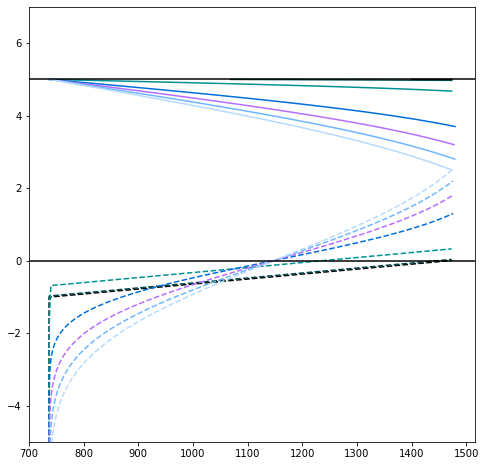

In [103]:
colors = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)


t_surface_eq = 0
l_lower = 0
l_upper = 0

## Compute lambda for lower crust conduction   
LHS_lower = L * np.pi ** 0.5 / c / (Tlava - Tsub)                                                ## Compute LHS of Stefan problem    
l_lower = lambdas[np.argmin(np.abs(LHS_lower - Stefan_lambda_upper(lambdas)))]                   ## Find value of lamba that produces RHS equal to the LHS   
    
    
## Model till surface temperature is equilibrated to the ambient temperature
## loop through all surface temperatures
for i, Ts in enumerate(Tsurf):
    
    ## Compute lambda for upper crust conduction   
    LHS_upper = L * np.pi ** 0.5 / c / (Tlava - Ts)                                                  ## Compute LHS of Stefan problem
    l_upper = lambdas[np.argmin(np.abs(LHS_upper - Stefan_lambda_upper(lambdas)))]                   ## Find value of lamba that produces RHS equal to the LHS   

    
    
    ## Compute time t by equating surface temperature gradient to heat flux through the surface
    Q_snyder = 1.07 * 1e-13 * Ts**4.85 * 1000                                                        ## heat flux in W/m2 using eq 8 of Flynn et al. 2023
    t_sqroot = k * (Tlava - Ts) / erf(l_upper) / (np.pi*kappa)**0.5 / Q_snyder
    t = t_sqroot**2
    t_surface_eq = t
    # print("Snyder's surface heat flux in W/m2 = ", Q_snyder)
#     print("time in hours = ", t/3600)  
    
    
    ## Compute crustal thickneess from lambda and time t
    C_lower = crustal_thickness(l_lower, kappa, t)
    C_upper = crustal_thickness(l_upper, kappa, t) 
    # print("upper_crust_thickness =", C_upper)
    # print("basal_crust_thickness =", C_lower)
    
    if abs(C_lower + C_upper - lava_thickness) <= 1e-3:
        print("lava solidification occured at or before ", t/3600, " hours")
        break
    
    ## Calculation of temperature profile for a 15 m thick lava flow before solidification
    y_lower = np.linspace(-100, C_lower, 100)
    T_lower = (((Tlava-Tsub) / (erf(l_lower)+1)) * (1 + erf(y_lower / 2/ (kappa*t)**0.5))) + Tsub
    # T_lower = temp_lower_crust(Tlava, Tsub, l_lower, kappa, y_lower, t)
       
    y_upper = np.linspace(0, C_upper, 100)
    T_upper = (((Tlava-Ts) / erf(l_upper)) * erf((y_upper) / 2/(kappa*t)**0.5)) + Ts
    # T_upper = temp_upper_crust(Tlava, Ts, l, kappa, y_upper, t):
    
    ax.plot(T_lower, y_lower, "--", color = colors[i])
    ax.plot(T_upper, lava_thickness-y_upper, color = colors[i])
    
###################################################################################################################    

## find the time at which the upper and lower crust meet
time_solid = 0
crustal_growth_period = np.arange(t_surface_eq, 4e7, 1)

for t in crustal_growth_period:
    ## Compute crustal thickneess from lambda and time t
    C_lower = crustal_thickness(l_lower, kappa, t)
    C_upper = crustal_thickness(l_upper, kappa, t)
    if C_lower + C_upper >= lava_thickness:  
            print("upper_crust_thickness =", C_upper)
            print("basal_crust_thickness =", C_lower)
            print("lava solidification occured at ", time_solid/3600, " hours")
            break
    time_solid = t
       
####################################################################################################################   

## Model after surface temperature os equilibrated to the ambient temperature
time = np.linspace(t_surface_eq, time_solid, 5)
z_upper_solid = 0
z_lower_solid = 0
T_upper_solid = 0
T_lower_solid = 0

dy = 1e-1
for i, t in enumerate(time):
    if i > 0:
        print("time in hours = ", t/3600)
        ## Compute crustal thickneess from lambda and time t
        C_lower = crustal_thickness(l_lower, kappa, t)
        C_upper = crustal_thickness(l_upper, kappa, t) 
#         print("upper_crust_thickness =", C_upper)
#         print("basal_crust_thickness =", C_lower)

        ## Calculation of temperature profile for a 15 m thick lava flow before solidification
        y_lower = np.arange(-100, C_lower+dy, dy)
        T_lower = (((Tlava-Tsub) / (erf(l_lower)+1)) * (1 + erf(y_lower / 2/ (kappa*t)**0.5))) + Tsub
        # Tz_lower = temp_lower_crust(Tlava, Tsub, l_lower, kappa, y_lower, t)

        y_upper = np.arange(0, C_upper+dy, dy)
        T_upper = (((Tlava-Tsub) / erf(l_upper)) * erf((y_upper) / 2/(kappa*t)**0.5)) + Tsub
        # Tz_upper = temp_upper_crust(Tlava, Ts, l, kappa, y_upper, t):
        
        if t==time[-1]:
            z_lower_solid = y_lower
            z_upper_solid = lava_thickness-y_upper
            T_lower_solid = T_lower
            T_upper_solid = T_upper
            

        ax.plot(T_lower, y_lower, "--", color = colors[5+i])
        ax.plot(T_upper, lava_thickness-y_upper, color = colors[5+i])

    
plt.axhline(5, color='k')
plt.axhline(0, color='k')

plt.ylim(-5, lava_thickness + 2)
plt.show()

### <b> Temperature profile through lava after solidifcation - test run </b>

In [123]:
## Setting up model domain
dz = dy
z_range = np.arange(-100, lava_thickness+dz, dz)              ## delta_x in meters

dt = 1e-3                                                     ## delta_t in seconds
time_total = time_solid + (20)
# t_range = np.arange(time_solid, time_total+dt, dt).astype(np.float32)

## Initial_condition
t = time_solid
z = np.concatenate((z_lower_solid, np.flip(z_upper_solid)[1:]), axis = 0)          ## join together lower crust z and upper crust z
T_n = np.concatenate((T_lower_solid, np.flip(T_upper_solid)[1:]), axis = 0)          ## join together lower crust T and upper crust T

## Note 1: Upper crust measuremnts are z downwards, so they need to be flipped 
## Note 2: The soldification point (z, T) are present in both the lower crust array and the upper crust array; removing the common (z, T) upper crust array.

m = 30
dprint = (time_total - time_solid) / m
printat = time_solid + dprint

T_PSC = np.zeros((m, len(z_range)), dtype=np.float32)

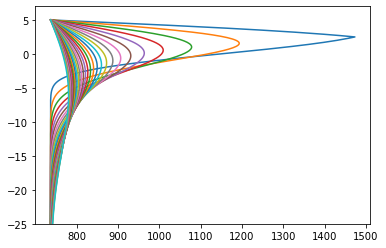

In [124]:
plt.figure()
plt.plot(T_n, z)
idx = 0
while t <= time_total:
    
    T_nplus = T_n + ( 
                    (k*dt/dz**2) * np.diff(T_n, n=2, prepend = T_n[0], append=T_n[-1]) 
                  )   
    
    # check whether to store output
    if t >= printat:
        # print(idx)
        # print(t/3600/24)
        T_PSC[idx, :] = T_nplus
        printat += dprint
        idx += 1
        plt.plot(T_nplus, z)
        
    # Update boundary_conditions
    T_nplus[0] = Tsub
    T_nplus[-1] = Tsub
    
    # variables for next step
    T_n = T_nplus
    t+=dt
    
plt.ylim(-25, lava_thickness + 2)
plt.show()   

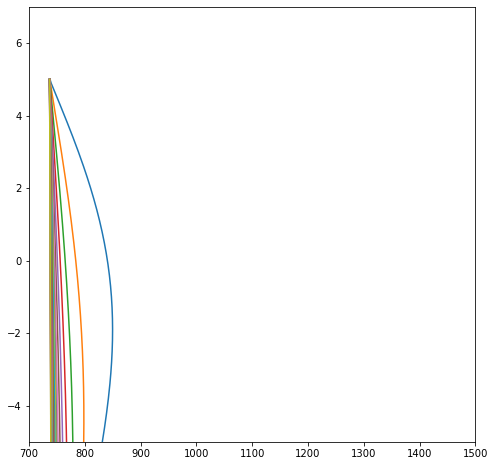

In [117]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)

for i in range(m):
    ax.plot(T_PSC[i], z)
    

plt.xlim(700, 1500)
plt.ylim(-5, lava_thickness + 2)
plt.show()    

In [20]:
T_PSC

array([[737.,  nan,  nan, ...,  nan,  nan, 737.],
       [737.,  nan,  nan, ...,  nan,  nan, 737.],
       [737.,  nan,  nan, ...,  nan,  nan, 737.],
       ...,
       [737.,  nan,  nan, ...,  nan,  nan, 737.],
       [737.,  nan,  nan, ...,  nan,  nan, 737.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)

In [42]:
.5**3 / 3

0.041666666666666664